# Cross Entropy Benchmarking (XEB)

To demonstrate the cross entropy benchmarking routine, consider a noise model with two independent
depolarising channels, one which only effects single qubit gates and a second that only effects
two qubit gates.

In [56]:
import cirq


class IndependentDepolariseNoiseModel(cirq.NoiseModel):
    """Applies single and two qubit depolarising channels independently"""

    def __init__(self, single_qubit_error: float, two_qubit_error: float) -> None:
        """Args:
        single_qubit_error: Single qubit error
        two_qubit_error: Two qubit error
        """
        super().__init__()
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error

        self.single_qubit_depolarise = cirq.DepolarizingChannel(p=single_qubit_error, n_qubits=1)
        self.two_qubit_depolarise = cirq.DepolarizingChannel(p=two_qubit_error, n_qubits=2)

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.Operation]:
        """Produces a list of operations by applying each noise model
        to the provided operation depending on the number of qubits it acts on.
        """
        if operation._num_qubits_() == 1:
            return [operation, self.single_qubit_depolarise(*operation.qubits)]

        if operation._num_qubits_() == 2:
            return [operation, self.two_qubit_depolarise(*operation.qubits)]

        return [operation]


noise = IndependentDepolariseNoiseModel(single_qubit_error=0.005, two_qubit_error=0.02)
simulator = cirq.DensityMatrixSimulator(
    noise=noise,
)

The XEB experiment allows us to estimate the fidelity of a "layer" composed of pair of single 
qubit gates followed by a two qubit gate. If each single qubit gate is effected by a depolarising
channel with rate $p_1$ and each two qubit gate is effected by a two qubit 
depolarising channel with rate $p_2$ the overall layer fidelity is
$$\frac{16}{15}\left( 1 - \left(1- p_1\right)^2 \left(1-p_2\right) \right) $$

In [57]:
from cirq_superstaq.qcvv import XEB

experiment = XEB()
experiment.run(100, layers=[1, 10, 25, 50, 75, 100], target=simulator)

Building circuits:   0%|          | 0/600 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/600 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/600 [00:00<?, ?it/s]

XEBResults(layer_fidelity_estimate=0.968576181672473, layer_fidelity_estimate_std=0.00015144930681678252)

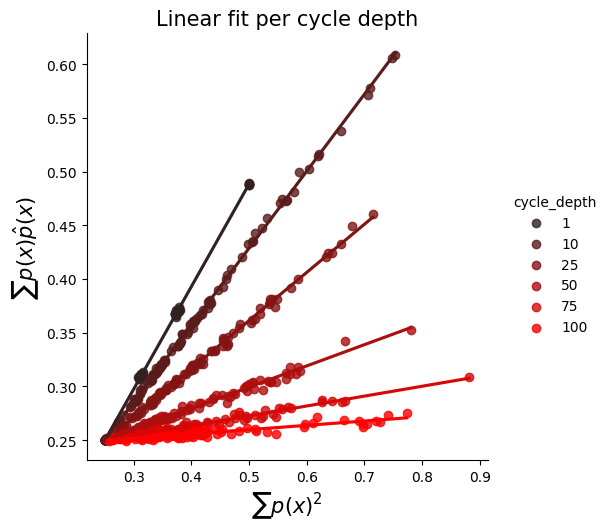

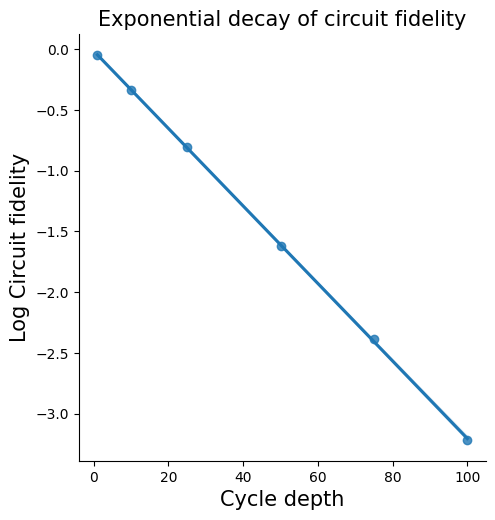

In [67]:
experiment.analyse_results()

In [66]:
layer_fidelity = 1 - 16 / 15 * (1 - (1 - 0.005) ** 2 * (1 - 0.02))
print("Layer fidelity: ", layer_fidelity)
print("Estimated layer fidelity: ", experiment.results.layer_fidelity_estimate)

Layer fidelity:  0.9682394666666667
Estimated layer fidelity:  0.968576181672473
